In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV

#### Since the first get data got garbage result for RNN, we try to get new data with a more similar # of days - set WS to Dec-April, and SA to April-Aug

In [2]:
dftest1 = pd.read_csv("vh_vv_data_new_20.csv").drop("Unnamed: 0", axis =1)
dftest2 = pd.read_csv("vh_vv_data_new_20_100.csv").drop("Unnamed: 0", axis =1)
dftest3 = pd.read_csv("vh_vv_data_new_100_200.csv").drop("Unnamed: 0", axis =1)
dftest4 = pd.read_csv("vh_vv_data_new_200_225.csv").drop("Unnamed: 0", axis =1)
dftest5 = pd.read_csv("vh_vv_data_new_225_300.csv").drop("Unnamed: 0", axis =1)
dftest6 = pd.read_csv("vh_vv_data_new_300_350.csv").drop("Unnamed: 0", axis =1)
dftest7 = pd.read_csv("vh_vv_data_new_350_400.csv").drop("Unnamed: 0", axis =1)
dftest8 = pd.read_csv("vh_vv_data_new_400_450.csv").drop("Unnamed: 0", axis =1)
dftest9 = pd.read_csv("vh_vv_data_new_450_500.csv").drop("Unnamed: 0", axis =1)
dftest10 = pd.read_csv("vh_vv_data_new_500_557.csv").drop("Unnamed: 0", axis =1)
dftest = pd.concat([dftest1,dftest2,dftest3,dftest4, dftest5,dftest6, dftest7, dftest8, dftest9,dftest10])

-----
### Baseline RNN
Use the padded version of data

In [3]:
def clean_from_df_pad(string):
    """
    takes in each cell as a string and replaces it with an array of float value. 
    Also pads the sequence to length 26
    """
    splitted = string.split(" ")
    result = []
    for i in splitted:
        number = float(i.replace(",","").replace("[", "").replace("]", ""))
        result.append(number)
    if len(result) !=26:
        missing = 26-len(result)
        comp = [0] * missing
        result = result + comp
    return np.asarray(result)

In [4]:
# read in those dataframes again before this
dftest["vv_list"] = dftest.vv_list.apply(clean_from_df_pad)
dftest["vh_list"] = dftest.vh_list.apply(clean_from_df_pad)
dftest['vv/vh_list'] = dftest['vv/vh_list'].apply(clean_from_df_pad)

In [5]:
# add a climate index called rvi
def calculate_rvi(vv, vh):
    """
    takes in a list of vvs and a list of vhs, return a list of their rvis
    dop = vv/(vv+vh)
    m = 1-dop
    m = np.sqrt(m)
    power_func = 4*vh/(vv+vh)
    rvi = m*power_func
    """
    if len(vv)!= len(vh):
        return None
    else:
        rvi_lst = []
        for i in range(len(vv)):
            rvi = np.sqrt(1-vv[i]/(vv[i]+vh[i])) * 4*vh[i]/(vv[i]+vh[i])
            rvi_lst.append(rvi)
    return rvi_lst

calculate_rvi_func = np.vectorize(calculate_rvi)

In [6]:
dftest["rvi"] = calculate_rvi(list(dftest.vv_list), list(dftest.vh_list))

In [7]:
# length is equal
def df_to_arr_equal_len (df):
    """
    takes in a df, which will be data, and transforms it into a 3-d array with its original size
    """
    # loop through every row in df
    res = []
    for i in range(df.shape[0]):
        row = list(df.iloc[i,:]) # each row of df is turned into a list of three elements, where each element is an array
        new_row = [] # one day, one location, three variables
        for var in row:
            new_row.append(var)
        res.append(new_row)
    return np.asarray(res)

In [8]:
arr = df_to_arr_equal_len(dftest)
np.isnan(arr).sum()

2504

In [9]:
# replace null rvi's with 0
arr = np.nan_to_num(arr, nan=0)
arr.shape

(557, 4, 26)

In [12]:
# use the first 500 data points as training
x = torch.from_numpy(arr[:500,:,:]).float().view(500,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"])).float()
training_dataset = MyDataset(x, y)
train_dataloader = DataLoader(training_dataset, batch_size=50, shuffle=True)

In [13]:
x.shape

torch.Size([500, 26, 4])

----
### Based on final report outline, try three more models: one with deeper layer, one with batch_size = 100, one with batch_size = 5
#### Deeper layer

In [17]:
# get gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cuda:0


In [18]:
# define baseline RNN, with batch norm
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, nonlinearity, 
                 dropout, bidirectional=False):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        h0 = torch.randn(self.num_layers, self.batch_size, self.hidden_size).requires_grad_().to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.bn(out[:, -1, :])
        out = self.fc(out)
        return out

In [27]:
# Define the RNN model
input_size = 4
hidden_size = 64
num_layers = 20
output_size = 1
batch_size = 50
RNNmodel = MyRNN(input_size, hidden_size, num_layers, output_size, batch_size, nonlinearity="tanh", dropout = 0.2)
RNNmodel.to(device)

MyRNN(
  (rnn): RNN(4, 64, num_layers=20, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [28]:
criterion = nn.L1Loss()
optimizer = optim.Adam(RNNmodel.parameters(), lr=0.008)
num_epochs = 500
print_freq = 59
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = RNNmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(running_loss/ len(train_dataloader))
    if epoch% print_freq ==1:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(train_dataloader)))
print("finished training")

Epoch [2/500], Loss: 6624.5819
Epoch [61/500], Loss: 2797.5500
Epoch [120/500], Loss: 673.9851
Epoch [179/500], Loss: 673.8430
Epoch [238/500], Loss: 673.8987
Epoch [297/500], Loss: 673.9438
Epoch [356/500], Loss: 674.4511
Epoch [415/500], Loss: 673.8665
Epoch [474/500], Loss: 673.9252
finished training


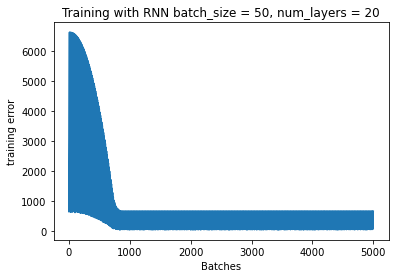

In [29]:
plt.plot(range(len(losses)), losses)
plt.xlabel("Batches")
plt.ylabel("training error")
plt.title("Training with RNN batch_size = 50, num_layers = 20")
plt.show()

In [30]:
RNNmodel.parameters

<bound method Module.parameters of MyRNN(
  (rnn): RNN(4, 64, num_layers=20, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)>

In [31]:
# testing results
print("Last error in training loss: ", losses[-1])
x = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"])).float()
testing_dataset = MyDataset(x, y)
test_dataloader = DataLoader(training_dataset, batch_size=50, shuffle=True)
# Evaluate the model on the test dataset
total_loss = 0.0
total_correct = 0

for batch in test_dataloader:
    inputs, targets = batch[0].to(device), batch[1].to(device)
    outputs = RNNmodel(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss.item()
print(total_loss, "\nTesting erorr: ",  total_loss/ len(test_dataloader))

Last error in training loss:  673.9224060058593
6739.212951660156 
Testing erorr:  673.9212951660156


####  Batch_size = 100 & ReLU, num_layers = 10

In [32]:
# use the first 500 data points as training
x = torch.from_numpy(arr[:500,:,:]).float().view(500,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"])).float()
training_dataset = MyDataset(x, y)
train_dataloader = DataLoader(training_dataset, batch_size=100, shuffle=True)

In [33]:
# Define the RNN model
input_size = 4
hidden_size = 64
num_layers = 10
output_size = 1
batch_size = 100
RNNmodel2 = MyRNN(input_size, hidden_size, num_layers, output_size, batch_size, nonlinearity="relu", dropout = 0.2)
RNNmodel2.to(device)

MyRNN(
  (rnn): RNN(4, 64, num_layers=10, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [34]:
criterion = nn.L1Loss()
optimizer = optim.Adam(RNNmodel2.parameters(), lr=0.008)
num_epochs = 500
print_freq = 59
losses2 = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = RNNmodel2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses2.append(running_loss/ len(train_dataloader))
    if epoch% print_freq ==1:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(train_dataloader)))
print("finished training")

Epoch [2/500], Loss: 6625.5868
Epoch [61/500], Loss: 5706.1187
Epoch [120/500], Loss: 2892.2199
Epoch [179/500], Loss: 673.9297
Epoch [238/500], Loss: 673.8054
Epoch [297/500], Loss: 673.8350
Epoch [356/500], Loss: 673.8290
Epoch [415/500], Loss: 673.8198
Epoch [474/500], Loss: 673.7693
finished training


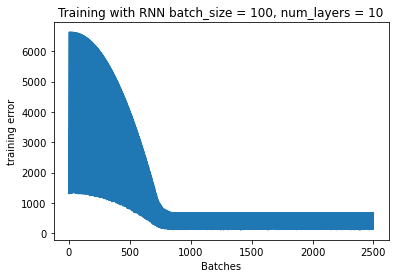

In [39]:
plt.plot(range(len(losses2)), losses2)
plt.xlabel("Batches")
plt.ylabel("training error")
plt.title("Training with RNN batch_size = 100, num_layers = 10")
plt.show()

In [40]:
RNNmodel2.parameters

<bound method Module.parameters of MyRNN(
  (rnn): RNN(4, 64, num_layers=10, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)>

In [48]:
# testing results
print("Last error in training loss: ", losses2[-1])
x = torch.from_numpy(arr[457:,:,:]).float().view(100,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[457:]["Rice Yield (kg/ha)"])).float()
testing_dataset = MyDataset(x, y)
#test_dataloader = DataLoader(training_dataset, batch_size=50, shuffle=True)


# Evaluate the model on the test dataset
total_loss = 0.0
total_correct = 0


inputs, targets = x.to(device), y.to(device)
outputs = RNNmodel2(inputs)
loss = criterion(outputs, targets)
print("\nSince 57 testing samples is not enough for batch size 100, leaked some of training samples into testing.\nTesting error: ", loss.item())

Last error in training loss:  673.75341796875

Since 57 testing samples is not enough for batch size 100, leaked some of training samples into testing.
Testing error:  722.7276000976562


#### Batch_size = 5 & ReLU, num_layers = 10, hidden_size = 200

In [49]:
# use the first 500 data points as training
x = torch.from_numpy(arr[:500,:,:]).float().view(500,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:500]["Rice Yield (kg/ha)"])).float()
training_dataset = MyDataset(x, y)
train_dataloader = DataLoader(training_dataset, batch_size=5, shuffle=True)

In [61]:
# Define the RNN model
input_size = 4
hidden_size = 200
num_layers = 10
output_size = 1
batch_size = 5
RNNmodel3 = MyRNN(input_size, hidden_size, num_layers, output_size, batch_size, nonlinearity="relu", dropout = 0)
RNNmodel3.to(device)

MyRNN(
  (rnn): RNN(4, 200, num_layers=10, batch_first=True)
  (bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [62]:
criterion = nn.L1Loss()
optimizer = optim.Adam(RNNmodel3.parameters(), lr=0.008)
num_epochs = 200
print_freq = 29
losses3 = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = RNNmodel3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses3.append(running_loss/ len(train_dataloader))
    if epoch% print_freq ==1:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(train_dataloader)))
print("finished training")

Epoch [2/200], Loss: 5979.0669
Epoch [31/200], Loss: 678.0060
Epoch [60/200], Loss: 678.1723
Epoch [89/200], Loss: 679.6716
Epoch [118/200], Loss: 676.7815
Epoch [147/200], Loss: 677.0352
Epoch [176/200], Loss: 676.2511
finished training


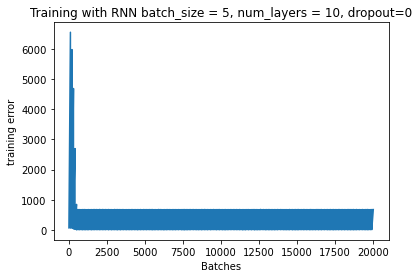

In [63]:
plt.plot(range(len(losses3)), losses3)
plt.xlabel("Batches")
plt.ylabel("training error")
plt.title("Training with RNN batch_size = 5, num_layers = 10, dropout=0")
plt.show()

In [64]:
RNNmodel3.parameters

<bound method Module.parameters of MyRNN(
  (rnn): RNN(4, 200, num_layers=10, batch_first=True)
  (bn): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)>

In [68]:
# testing results
print("Last error in training loss: ", losses3[-1])

print("Since 57% batch_size = 5 is not 0, left out 2 testing samples.\n ")
x = torch.from_numpy(arr[502:,:,:]).float().view(55,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[502:]["Rice Yield (kg/ha)"])).float()
testing_dataset = MyDataset(x, y)
test_dataloader = DataLoader(training_dataset, batch_size=5, shuffle=True)
# Evaluate the model on the test dataset
total_loss = 0.0

for batch in test_dataloader:
    inputs, targets = batch[0].to(device), batch[1].to(device)
    outputs = RNNmodel3(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss.item()
print(total_loss, "\nTesting erorr: ",  total_loss/ len(test_dataloader))

Last error in training loss:  676.3331457519531
Since 57% batch_size = 5 is not 0, left out 2 testing samples.
 
67421.65063476562 
Testing erorr:  674.2165063476563


----

In [13]:
# define baseline RNN, with batch norm
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, nonlinearity, 
                 dropout, bidirectional=False):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.randn(self.num_layers, self.batch_size, self.hidden_size).requires_grad_().to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.bn(out[:, -1, :])
        out = self.fc(out)
        return out

In [18]:
# Define the RNN model
input_size = 4
hidden_size = 64
num_layers = 5
output_size = 1
batch_size = 50
RNNmodel = MyRNN(input_size, hidden_size, num_layers, output_size, batch_size, nonlinearity="tanh", dropout = 0.1)
RNNmodel.to(device)

MyRNN(
  (rnn): RNN(4, 64, num_layers=5, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [19]:
criterion = nn.L1Loss()
optimizer = optim.Adam(RNNmodel.parameters(), lr=0.008)
num_epochs = 2000
print_freq = 299
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = RNNmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(running_loss/ len(train_dataloader))
    if epoch% print_freq ==1:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(train_dataloader)))
print("finished training")

Epoch [2/2000], Loss: 6624.3866
Epoch [301/2000], Loss: 673.8586
Epoch [600/2000], Loss: 674.1784
Epoch [899/2000], Loss: 674.0617
Epoch [1198/2000], Loss: 673.9161
Epoch [1497/2000], Loss: 674.2348
Epoch [1796/2000], Loss: 673.9398
finished training


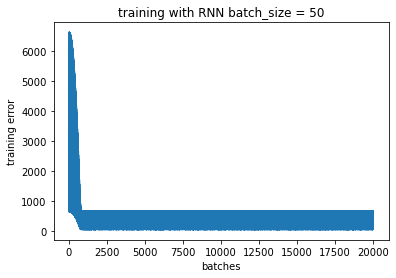

In [20]:
plt.plot(range(len(losses)), losses)
plt.xlabel("batches")
plt.ylabel("training error")
plt.title("training with RNN batch_size = 50")
plt.show()

In [21]:
losses[-1]

673.9173095703125

In [22]:
# see testing result
# create testing dataloader
# use the last 57 data points as testing
x = torch.from_numpy(arr[500:,:,:]).float().view(57,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[500:]["Rice Yield (kg/ha)"])).float()
testing_dataset = MyDataset(x, y)
test_dataloader = DataLoader(training_dataset, batch_size=50, shuffle=True)

In [50]:
# Evaluate the model on the test dataset
total_loss = 0.0
total_correct = 0

for batch in test_dataloader:
    inputs, targets = batch[0].to(device), batch[1].to(device)
    outputs = RNNmodel(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss.item()
print(total_loss, "\n",  total_loss/ len(test_dataloader))

6738.3404541015625 
 673.8340454101562


-----

### Try another model with same parameters but different criterion
- Run into infinite loss while doing grid search with SGD, so changed criterion into L1 Loss (MAE)
- Used learning rate 0.001, but loss not changing

In [39]:
# Define the RNN model
input_size = 4
hidden_size = 132
num_layers = 6
output_size = 1
batch_size = 50
RNNmodel_1 = MyRNN(input_size, hidden_size, num_layers, output_size, batch_size, nonlinearity="relu", dropout = 0.1)
RNNmodel_1.to(device)

MyRNN(
  (rnn): RNN(4, 132, num_layers=6, batch_first=True)
  (bn): BatchNorm1d(132, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=132, out_features=1, bias=True)
)

In [40]:
input_size = 4
hidden_size = 132
num_layers = 6
output_size = 1
batch_size = 50
RNNmodel_1 = MyRNN(input_size, hidden_size, num_layers, output_size, batch_size, nonlinearity="relu", dropout = 0.1)
RNNmodel_1.to(device)
criterion = nn.L1Loss() # use L1 Loss instead of MSE
optimizer = optim.SGD(RNNmodel_1.parameters(), lr=0.003, momentum = 0.9)
#optimizer = optim.Adam(RNNmodel.parameters(), lr=0.00009)
num_epochs = 1000
print_freq = 59
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = RNNmodel_1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(running_loss/ len(train_dataloader))
    if epoch% print_freq ==1:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(train_dataloader)))
print("finished training")

Epoch [2/1000], Loss: 6625.5419
Epoch [61/1000], Loss: 676.9724
Epoch [120/1000], Loss: 675.0412
Epoch [179/1000], Loss: 674.2905
Epoch [238/1000], Loss: 675.4186
Epoch [297/1000], Loss: 675.7827
Epoch [356/1000], Loss: 674.6837
Epoch [415/1000], Loss: 680.8221
Epoch [474/1000], Loss: 675.8473
Epoch [533/1000], Loss: 674.3854
Epoch [592/1000], Loss: 674.9197
Epoch [651/1000], Loss: 674.8596
Epoch [710/1000], Loss: 675.3696
Epoch [769/1000], Loss: 676.5933
Epoch [828/1000], Loss: 674.3798
Epoch [887/1000], Loss: 676.6328
Epoch [946/1000], Loss: 677.6230
finished training


RNN hidden_size = 132, num_layers = 6, optimizer = SGD(lr=0.003, momemtum=0.9),nonlinearity = ReLU 


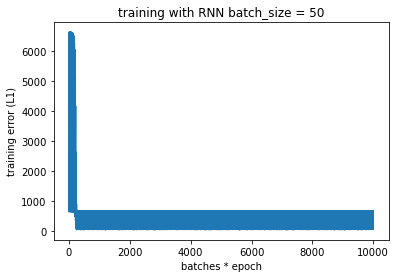

In [43]:
print("RNN hidden_size = 132, num_layers = 6, optimizer = SGD(lr=0.003, momemtum=0.9),nonlinearity = ReLU ")
plt.plot(range(len(losses)), losses)
plt.xlabel("batches * epoch")
plt.ylabel("training error (L1)")
plt.title("training with RNN batch_size = 50")
plt.show()

In [52]:
losses[-1]

674.2167907714844

In [51]:
# Evaluate the model on the test dataset
total_loss = 0.0
total_correct = 0
for batch in test_dataloader:
    inputs, targets = batch[0].to(device), batch[1].to(device)
    outputs = RNNmodel_1(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss.item()
print(total_loss, "\n",  total_loss/ len(test_dataloader))

6739.5533447265625 
 673.9553344726562


### Manual grid search
Need to change the optimizer every time

In [38]:
# parameters that are fixed
input_size = 4
output_size = 1

- Run into infinite loss while doing grid search with SGD, so changed criterion into L1 Loss (MAE)
- Loss wasn't decreasing in last model, so change `optimizer` to SGD

In [126]:
# Define a grid search manually - prepare dataset (batch), define net, then train
def train_model(num_epochs, batch_freq,
                print_iters, criterion, hidden_size, num_layers, 
                # optimizer 
                batch_size, nonlinearity, dropout):
    # prepare training data
    train_dataloader = DataLoader(training_dataset, batch_size, shuffle=True)
    
    # define model
    RNNmodel = MyRNN(input_size, hidden_size, num_layers, output_size, 
                     batch_size, nonlinearity, dropout)
    RNNmodel.to(device)
    
    
    # define an optimizer - unable to put into function param so manually change
    optimizer = optim.SGD(RNNmodel.parameters(), lr=0.0009, momentum = 0.9)
    print("Optimizer: ", optimizer)
    
    
    # train model
    losses = []
    print_iters = print_iters
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = RNNmodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if epoch% print_iters ==1 and i% batch_freq ==1:
                print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(train_dataloader)))
        losses.append(running_loss/ len(train_dataloader)) # append the average of all batches in that iteration
            
    print("finished training")
    return RNNmodel, losses

**Baseline:** input_size = 4, hidden_size = 64, num_layers = 5, output_size = 1, batch_size = 50, nonlinearity="tanh", dropout = 0.1

Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0009
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Epoch [2/3000], Loss: 1321.5668
Epoch [2/3000], Loss: 3959.4095
Epoch [2/3000], Loss: 6625.9163
Epoch [311/3000], Loss: 120.0425
Epoch [311/3000], Loss: 415.4381
Epoch [311/3000], Loss: 674.1265
Epoch [620/3000], Loss: 136.3314
Epoch [620/3000], Loss: 400.1161
Epoch [620/3000], Loss: 673.8686
Epoch [929/3000], Loss: 141.7753
Epoch [929/3000], Loss: 409.4589
Epoch [929/3000], Loss: 674.2873
Epoch [1238/3000], Loss: 140.9510
Epoch [1238/3000], Loss: 387.2481
Epoch [1238/3000], Loss: 674.4110
Epoch [1547/3000], Loss: 130.3742
Epoch [1547/3000], Loss: 409.2029
Epoch [1547/3000], Loss: 674.0973
Epoch [1856/3000], Loss: 149.0251
Epoch [1856/3000], Loss: 426.9746
Epoch [1856/3000], Loss: 673.9631
Epoch [2165/3000], Loss: 136.5861
Epoch [2165/3000], Loss: 403.6590
Epoch [2165/3000], Loss: 674.8689
Epoch [

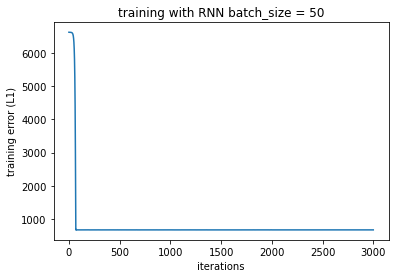

In [127]:
# Only change the optimizer from baseline to SGD
mod1, loss1 = train_model(num_epochs = 3000, print_iters = 309, batch_freq = 4, criterion = nn.L1Loss(), hidden_size = 64, num_layers = 5, 
                        batch_size = 50, nonlinearity = "tanh", dropout = 0.1)



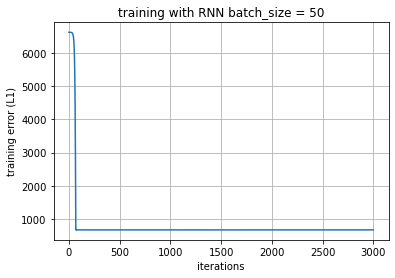

In [136]:
plt.plot(range(len(loss1)), loss1)
plt.xlabel("iterations")
plt.ylabel("training error (L1)")
plt.title("training with RNN batch_size = 50")
plt.grid()
plt.show()

In [131]:
# Evaluate the model on the test dataset
total_loss = 0.0
total_correct = 0

for batch in test_dataloader:
    inputs, targets = batch[0].to(device), batch[1].to(device)
    outputs = mod1(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss.item()
print(mod1, total_loss)

MyRNN(
  (rnn): RNN(4, 64, num_layers=5, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
) 6739.3155517578125


In [132]:
# final epoch training loss
loss1[-1]

674.3602783203125

### Second modified model - SGD, deeper layer

- Baseline: input_size = 4, hidden_size = 64, num_layers = 5, output_size = 1, optimizer = Adam(lr = 0.001), batch_size = 50, nonlinearity="tanh", dropout = 0.1, criterion = MSE

- Mod1: input_size = 4, hidden_size = 64, num_layers = 5, output_size = 1, **optimizer = SGD(lr = 0.0009, momentum = 0.9)**, batch_size = 50, nonlinearity="tanh", dropout = 0.1, **criterion = L1**

- **Tried several combinations of diff hyperparams, but still doesn't converge (can't get past local min at 670), so use the first 550 data points for training**

- Mod2: num_epochs = 300, print_iters = 35, batch_freq = 4, criterion = nn.L1Loss(), **hidden_size = 128**, **num_layers = 15**, **batch_size = 22**, **nonlinearity = "relu"**, **dropout = 0.3**, optimier = SGD(RNNmodel.parameters(), **lr=0.0015, momentum = 0.8**)

In [53]:
# Define a grid search manually - prepare dataset (batch), define net, then train
def train_model2(num_epochs, batch_freq,
                print_iters, criterion, hidden_size, num_layers, 
                # optimizer 
                batch_size, nonlinearity, dropout):
    # prepare training data
    train_dataloader = DataLoader(training_dataset, batch_size, shuffle=True)
    
    # define model
    RNNmodel = MyRNN(input_size, hidden_size, num_layers, output_size, 
                     batch_size, nonlinearity, dropout)
    RNNmodel.to(device)
    
    # define an optimizer - unable to put into function param so manually change
    optimizer = optim.SGD(RNNmodel.parameters(), lr=0.0015, momentum = 0.8)
    print("Optimizer: ", optimizer)
    
    # train model
    losses = []
    print_iters = print_iters
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = RNNmodel(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if epoch% print_iters ==1 and i% batch_freq ==1:
                print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, running_loss / len(train_dataloader)))
        losses.append(running_loss/ len(train_dataloader)) # append the average of all batches in that iteration
            
    print("finished training")
    return RNNmodel, losses

In [161]:
x = torch.from_numpy(arr[:550]).float().view(550,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[:550]["Rice Yield (kg/ha)"])).float()
training_dataset = MyDataset(x, y)
#train_dataloader = DataLoader(training_dataset, batch_size=50, shuffle=True)

In [54]:
# Increase learning rate to 0.00095, increase number of layers to 10
mod2, loss2 = train_model2(num_epochs = 300, print_iters = 35, batch_freq = 4, criterion = nn.L1Loss(), hidden_size = 128, 
                          num_layers = 15, 
                        batch_size = 22, nonlinearity = "relu", dropout = 0.3)

plt.plot(range(len(loss2)), loss2)
plt.xlabel("iterations")
plt.ylabel("training error (L1)")
plt.title("training with RNN batch_size = 50")
plt.show()

Optimizer:  SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.0015
    maximize: False
    momentum: 0.8
    nesterov: False
    weight_decay: 0
)


RuntimeError: Expected hidden size (15, 16, 128), got [15, 22, 128]

In [176]:
# see testing result
# create testing dataloader
# use the last 57 data points as testing
x = torch.from_numpy(arr[550:,:,:]).float().view(7,26,4)
y = torch.from_numpy(np.asarray(
            pd.read_csv("Crop_Yield_Data_challenge_2.csv")[550:]["Rice Yield (kg/ha)"])).float()
testing_dataset = MyDataset(x, y)
test_dataloader = DataLoader(training_dataset, batch_size=22, shuffle=True)

In [177]:
# Evaluate the model on the test dataset
total_loss = 0.0
total_correct = 0

for batch in test_dataloader:
    inputs, targets = batch[0].to(device), batch[1].to(device)
    outputs = mod2(inputs)
    loss = criterion(outputs, targets)
    total_loss += loss.item()
print(mod1, total_loss)

MyRNN(
  (rnn): RNN(4, 64, num_layers=5, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
) 17015.088012695312


In [178]:
total_loss/7

2430.7268589564733

-----
-----

-----
-----
#### *Helper functions - run these first before training any model*

In [11]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y